In [318]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import warnings 
warnings.simplefilter('ignore')

sns.set(rc = {'figure.figsize': (10, 10)})
%matplotlib inline

In [319]:
df = pd.read_csv('data/user_influencer_pairs.csv')
df.head()

,followId,FollowerId,InfluencerId
0,11,87E2923A-FD01-43AC-8369-864081916F83,8E665D3B-F5CD-48D2-8103-4B74B79A405F
1,20,371088ec-ccd9-4c1e-acb3-6c3b43c84627,f7e6dd70-1b33-4d36-916b-c31e655555b5
2,21,24f13669-d3c4-431b-ae72-7c445aec412c,f7e6dd70-1b33-4d36-916b-c31e655555b5
3,22,a328005f-1ca5-4c79-961f-4eab118a32ab,b0871e46-0322-4934-9b04-49dcf3ce3130
4,23,a328005f-1ca5-4c79-961f-4eab118a32ab,bce93b7e-f594-4117-a354-1051f10fd56c


In [320]:
df.shape

(5380, 3)

In [321]:
#remove the 'following myself' cases
df = df[df['FollowerId']!=df['InfluencerId']]

In [322]:
df.shape

(4162, 3)

In [323]:
df[df['FollowerId']==df['InfluencerId']] #

,followId,FollowerId,InfluencerId


In [324]:
follower_id = df.FollowerId
influencer_id = df.InfluencerId
all_id = follower_id.append(influencer_id)
all_id = all_id.astype('category').cat.codes
follower_id_codes = all_id[:len(follower_id)]
influencer_id_codes = all_id[len(follower_id):]
df['FollowerCode'] = follower_id_codes
df['InfluencerCode'] = influencer_id_codes
df_updated = df.drop(columns = ['followId', 'FollowerId', 'InfluencerId'])

In [325]:
df_updated.head()

,FollowerCode,InfluencerCode
0,1723,1756
1,727,3167
2,493,3167
3,2069,2230
4,2069,2401


In [326]:
df_updated[df_updated['FollowerCode']==df_updated['InfluencerCode']] #should be empty

,FollowerCode,InfluencerCode


## Exploratory Analysis

#### Distribution of number of followers

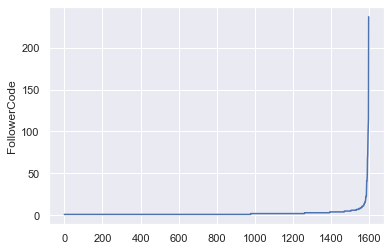

In [327]:
a = df_updated.groupby('InfluencerCode')[['FollowerCode']].count().sort_values(by = 'FollowerCode').reset_index()
sns.lineplot(x =a.index, y ='FollowerCode', data = a)

#### Distribution of number following

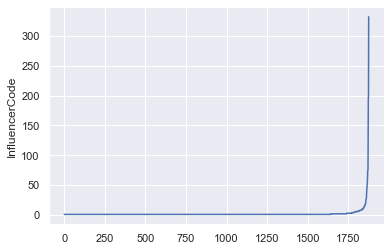

In [328]:
a = df_updated.groupby('FollowerCode')[['InfluencerCode']].count().sort_values(by = 'InfluencerCode').reset_index()
sns.lineplot(x =a.index, y ='InfluencerCode', data = a)

# Building Graph

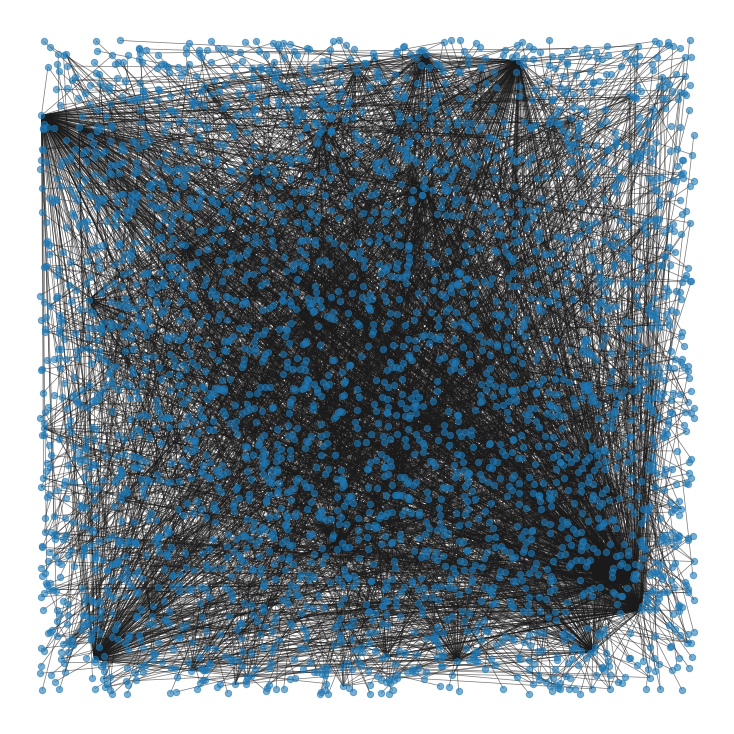

In [329]:
#we assume that the graph is undirected
G = nx.from_pandas_edgelist(df = df_updated, source = 'FollowerCode', target = 'InfluencerCode', 
                            create_using = nx.Graph())
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

# Generating Training Data

Here, we calculate missing edges by considering nodes that are far apart, reducing their likelihood of being connected in the future. This metrics needs to be solidified

We later use downsampling to take a subset of these missing edges to account for an extreme imbalance in the data

## Are we looking at directed graph cuz then we need to change this using nx.DiGraph()

In [330]:
follower_list = df_updated.FollowerCode.unique().tolist()
influencer_list = df_updated.InfluencerCode.unique().tolist()

df_train_pos = pd.DataFrame(columns = ['node1', 'node2', 'link'])
df_train_pos['link'] = 1
df_train_pos['node1'] = df_updated.FollowerCode
df_train_pos['node2'] = df_updated.InfluencerCode

#generating negative samples
missing_edge = []
for i in tqdm(follower_list):
    for j in influencer_list:
        if i != j:
            try:
                #this is an assumption, we need to determine a quality metric for this one
                #perhaps if far apart + the j is not an influencer
                if nx.shortest_path_length(G, i, j) > 5:
                    missing_edge.append([i, j])

            except nx.NetworkXNoPath:
                missing_edge.append([i, j])

missing_edge
            

100%|██████████| 1877/1877 [01:38<00:00, 19.15it/s]


[[1723, 3167],
 [1723, 2230],
 [1723, 2401],
 [1723, 828],
 [1723, 2768],
 [1723, 2860],
 [1723, 2616],
 [1723, 799],
 [1723, 641],
 [1723, 2092],
 [1723, 211],
 [1723, 2484],
 [1723, 2633],
 [1723, 778],
 [1723, 338],
 [1723, 484],
 [1723, 1800],
 [1723, 1735],
 [1723, 1677],
 [1723, 1868],
 [1723, 1119],
 [1723, 3203],
 [1723, 1434],
 [1723, 736],
 [1723, 1224],
 [1723, 2065],
 [1723, 790],
 [1723, 3016],
 [1723, 118],
 [1723, 816],
 [1723, 3229],
 [1723, 29],
 [1723, 3079],
 [1723, 42],
 [1723, 131],
 [1723, 2795],
 [1723, 2880],
 [1723, 1158],
 [1723, 436],
 [1723, 2150],
 [1723, 2821],
 [1723, 2374],
 [1723, 2652],
 [1723, 2561],
 [1723, 2358],
 [1723, 1574],
 [1723, 1266],
 [1723, 0],
 [1723, 3071],
 [1723, 1192],
 [1723, 205],
 [1723, 1986],
 [1723, 1335],
 [1723, 645],
 [1723, 2513],
 [1723, 2678],
 [1723, 3141],
 [1723, 487],
 [1723, 23],
 [1723, 1443],
 [1723, 1809],
 [1723, 2851],
 [1723, 2870],
 [1723, 3226],
 [1723, 868],
 [1723, 2842],
 [1723, 2942],
 [1723, 872],
 [1723,

In [331]:
from sklearn.utils import resample
df_train_neg = pd.DataFrame(missing_edge)
df_train_neg = resample(df_train_neg, 
                        replace=False,    # no replacement
                        n_samples=4000,     # close to the minority class
                        random_state=42)
df_train_neg['link'] = 0
df_train_neg.columns = ['node1', 'node2', 'link']
df_train_neg.head()

,node1,node2,link
545958,1107,2652,0
769519,2894,2534,0
128749,3012,1967,0
1232950,2198,1498,0
1102560,1097,2960,0


In [332]:
df_train_neg.shape

(4000, 3)

In [333]:
df_train_pos['link'] = 1
df_train = pd.concat([df_train_pos, df_train_neg])


# Drop some edges to make model robust (Optional)

# Feature Engineering

In [334]:
!pip install neo4j

#### Functions to compute Metrics

In [335]:
def jaccard(node1, node2, Graph = G):
    pred = nx.jaccard_coefficient(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p
    
def adamic_adar(node1, node2, Graph = G):
    pred = nx.adamic_adar_index(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p
    
def resource_allocation_index(node1, node2, Graph = G):
    pred = nx.resource_allocation_index(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p

def cosine_similarity(node1, node2, Graph = G):
    neighbor1 = set(G.neighbors(node1))
    neighbor2 = set(G.neighbors(node2))
    
    return (len(neighbor1.intersection(neighbor2))/(np.sqrt(len(neighbor1)*len(neighbor2))))

def preferential_attachment(node1, node2, Graph = G):
    pred = nx.preferential_attachment(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p
    
def sorensen_index(node1, node2, Graph = G):
    sum_deg = G.degree(node1)+G.degree(node2)
    neighbor1 = set(G.neighbors(node1))
    neighbor2 = set(G.neighbors(node2))
    try:
        return (2*len(neighbor1.intersection(neighbor2)))/(sum_deg)
    except:
        return -1

def lhni(node1, node2, Graph = G):
    prod_deg = G.degree(node1)*G.degree(node2)
    neighbor1 = set(G.neighbors(node1))
    neighbor2 = set(G.neighbors(node2))
    try:
        
        return (len(neighbor1.intersection(neighbor2)))/(prod_deg)
    except:
        return -1

#tes
def shortest_walk(node1, node2, Graph = G):
    sw = 0
    try:
        if G.has_edge(node1, node2):
            G.remove_edge(node1, node2)
            sw = nx.shortest_path_length(G, node1, node2)
            G.add_edge(node1, node2)
        else:
            sw = nx.shortest_path_length(G, node1, node2)
        
        return sw
    except nx.NetworkXNoPath:
        return -1 #we can change this and put something else

def hopcroft(node1, node2, Graph = G):
    pred = nx.ra_index_soundarajan_hopcroft(G, ebunch = [(node1, node2)])
    for u, v, p in pred:
        return p

#we can add more and others as we see fit...

In [336]:
#number of nodes with degree 0

temp_list = list(set(df_train.node1.append(df_train.node2).values))
l = 0
for node in temp_list:
    if G.degree(node)==0:
        l+=1
l/len(temp_list)

#80% of nodes have a degree of 0? => we need to change the strategy for generating the training set?

0.0

In [337]:
#Add engineered features to data

df_train['jaccard'] = df_train.drop(columns = ['link']).apply(lambda row: jaccard(row['node1'], row['node2']), axis = 1)
df_train['adamic_adar'] = df_train.drop(columns = ['link']).apply(lambda row: adamic_adar(row['node1'], row['node2']), axis = 1)
df_train['resource_allocation_index'] = df_train.drop(columns = ['link']).apply(lambda row: resource_allocation_index(row['node1'], row['node2']), axis = 1)
df_train['cosine_similarity'] = df_train.drop(columns = ['link']).apply(lambda row: cosine_similarity(row['node1'], row['node2']), axis = 1)
df_train['preferential_attachment'] = df_train.drop(columns = ['link']).apply(lambda row: preferential_attachment(row['node1'], row['node2']), axis = 1)
df_train['sorensen'] = df_train.drop(columns = ['link']).apply(lambda row: sorensen_index(row['node1'], row['node2']), axis = 1)
df_train['lhni'] = df_train.drop(columns = ['link']).apply(lambda row: lhni(row['node1'], row['node2']), axis = 1)
df_train['shortest_walk'] = df_train.drop(columns = ['link']).apply(lambda row: shortest_walk(row['node1'], row['node2']), axis = 1)
# df_train['hopcroft'] = df_train.drop(columns = ['link']).apply(lambda row: hopcroft(row['node1'], row['node2']), axis = 1)


In [338]:
df_train.head()

,node1,node2,link,jaccard,adamic_adar,resource_allocation_index,cosine_similarity,preferential_attachment,sorensen,lhni,shortest_walk
0,1723,1756,1,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,-1
1,727,3167,1,0.000000,0.000000,0.000000,0.000000,146,0.000000,0.000000,3
2,493,3167,1,0.000000,0.000000,0.000000,0.000000,4,0.000000,0.000000,3
3,2069,2230,1,0.029046,1.974852,0.231129,0.074557,8815,0.056452,0.000794,2
4,2069,2401,1,0.066667,5.649903,0.821769,0.133370,20295,0.125000,0.000936,2


In [339]:
from sklearn.preprocessing import StandardScaler
df_train['cosine_similarity'] = df_train['cosine_similarity'].fillna(0)

In [340]:
df_important = df_train[['node1','node2','link']]

In [341]:
numerical_cols = df_train.drop(columns=['node1', 'node2', 'link'],axis=1).columns

In [342]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
numerical_data_imputed_normalized = pd.DataFrame(
    #We're created a new dataframe where our columns have been imputed and normalized
    normalize(SimpleImputer(strategy="median").fit_transform(df_train[numerical_cols])),
    columns=numerical_cols
)

In [343]:
df_train = pd.concat([
    numerical_data_imputed_normalized.reset_index(drop=True),
    df_important.reset_index(drop=True)
], axis=1)

In [344]:
x_train = df_train.drop(columns = ['link'])
y_train = df_train.link

sc = StandardScaler()
x_train = sc.fit_transform(x_train)

In [345]:
x_train

array([[-0.0534006 , -0.06093345, -0.04326196, ..., -1.19822312,
         0.01089127,  0.15860428],
       [-0.0534006 , -0.06093345, -0.04326196, ...,  1.09390346,
        -1.03526057,  1.63157597],
       [-0.0534006 , -0.06093345, -0.04326196, ...,  2.91921326,
        -1.28104323,  1.63157597],
       ...,
       [-0.0534006 , -0.06093345, -0.04326196, ...,  0.2651938 ,
        -0.44076063, -0.03034532],
       [-0.0534006 , -0.06093345, -0.04326196, ..., -0.37954964,
        -0.10779865,  1.31526809],
       [-0.0534006 , -0.06093345, -0.04326196, ...,  0.03306074,
        -0.02587109, -0.65252188]])

# Creating the Model

### Logistic Regression

In [377]:
lr = LogisticRegression()
lr.fit(x_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [378]:
from sklearn import metrics

In [379]:
pred = lr.predict(x_train)

In [380]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_train, pred)



array([[3614,  386],
       [ 906, 3256]], dtype=int64)

In [381]:
from sklearn.model_selection import cross_val_score
cross_val_score(
    lr, x_train, y_train, scoring="accuracy", cv=5
).mean()

0.8391332114597218

In [382]:
cross_val_score(
    lr, x_train, y_train, scoring="recall", cv=5
).mean()

0.780405912364946

In [385]:
cross_val_score(
    lr, x_train, y_train, scoring="precision", cv=5
).mean()

0.890558808728343

In [384]:
cross_val_score(
    lr, x_train, y_train, scoring="f1", cv=5
).mean()

0.828812254739616

### Decision Tree

In [354]:
classifier = DecisionTreeClassifier(max_depth = 5)
classifier.fit(x_train, y_train)
pred = classifier.predict(x_train)

In [355]:
confusion_matrix(y_train, pred)


array([[3854,  146],
       [1091, 3071]], dtype=int64)

In [356]:
cross_val_score(
    classifier, x_train, y_train, scoring="accuracy", cv=5
).mean()

0.8366844073820587

In [357]:
cross_val_score(
    classifier, x_train, y_train, scoring="recall", cv=5
).mean()

0.7335531327915781

In [358]:
cross_val_score(
    classifier, x_train, y_train, scoring="precision", cv=5
).mean()

0.9306025248149034

In [359]:
cross_val_score(
    classifier, x_train, y_train, scoring="f1", cv=5
).mean()

0.8163361039194899

False negatives are happening often which is very bad for the network and this is due to absurd instances in the training set which we need to account for. false positives are rare 

In [360]:
pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

# Evaluating the Model

In [364]:
nx.jaccard_coefficient(G, ebunch = [(1722, 1755)])

<generator object _apply_prediction.<locals>.<genexpr> at 0x000001E1E0A66248>

In [365]:
np.sqrt(2)

1.4142135623730951

In [366]:
sum(df_train['link']!=0)

4162

In [367]:
sorensen_index(1722, 1755)
print(G.degree(1722))
print(G.degree(1755))
print(G.degree(727))

0
2
60
